# Stanford Car Model Training

Model is built with fast.ai v1 and PyTorch v1, trained on Google Cloud Platform's Deep Learning VM with 16GB NVIDIA Tesla T4.

Data consist of 8144 Training Images (80:20 Train:Validation Split) and 8041 Test Images. 

Architecture used is ResNet-152 with squared image (299x299), pretrained with ImageNet. Data is augmented with several affine and perspective transformation. Mixup technique is used. 

Final Top-1 Accuracy is **92.53%** on Test Images.

In [2]:
## Ipython Commands 

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Importing Libraries
Libraries that are used to train this models are:
* Fast.ai : Deep Learning library which is built on top of PyTorch
* SciPy : Scientific toolkit to load Matlab files
* Pandas : Data manipulation library to organize datas

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate
from scipy.io import loadmat
import pandas as pd

# Data Preparation

## Preparing Training Data
#### Download data from source

In [15]:
url = "http://imagenet.stanford.edu/internal/car196/cars_train"
url_label = "https://ai.stanford.edu/~jkrause/cars/car_devkit"

# path = untar_data(url);
# path_label = untar_data(url_label); path_label

path = Path('/home/jupyter/.fastai/data/cars_train');
path_label = Path('/home/jupyter/.fastai/data/devkit');

tfms = get_transforms()

 #### Load Matlab Files and convert them to Pandas dataframe with desirable format

In [16]:
## Training Data Cleaning
mat_data = loadmat(path_label/'cars_train_annos.mat')
mat_meta = loadmat(path_label/'cars_meta.mat')

class_id_label = mat_data['annotations']["class"].squeeze()
fname = mat_data['annotations']["fname"].squeeze()
class_names = mat_meta['class_names'].squeeze()

class_id_label_list = [class_id[0][0] for class_id in class_id_label]
fname_list = [f[0] for f in fname]
class_names_list = [c[0] for c in class_names]

# Mapping id to classnames for verboseness
class_name_label_list = [class_names_list[idx-1] for idx in class_id_label_list] 

train_df = pd.DataFrame(
    {'fname': fname_list,
     'label': class_name_label_list,
    })

In [17]:
train_df.head()

,fname,label
0,00001.jpg,Audi TTS Coupe 2012
1,00002.jpg,Acura TL Sedan 2012
2,00003.jpg,Dodge Dakota Club Cab 2007
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012


## Data Augmentation
Data augmentation is the most important regularization technique in Deep Learning, especially in Vision domain because we can almost always apply some augmentation techniques in images. This increase the variety in training features that helps the model to generalize better.

`get_transforms()` provides a handy amount of transformation to the training data. After experimenting with different settings, I found out that the fastai's default settings works best on our case.

Each data has: 
50% to perform 
* Horizontal Flip

75% to perform
* Rotation of maximum ±10 degrees
* Zoom between 100% - 110% (equally probable)
* Symmetric Warp 0.2 Magnitude in any direction
* Brightness Change of ±20%
* Contrast Change of ±20%

PS: These transformation are only applied to Training Set. Does not apply to Validation and Test Set

In [18]:
## Transformation for Data Augmentation
tfms = get_transforms()

## Preparing Training Databunch

In [36]:
data = (
    ImageList
    .from_df(df=train_df, path=path)
    .split_by_rand_pct(valid_pct=0.2, seed=1010) # Seed to make sure validation set is the same everytime we repeat an experiment
    .label_from_df(cols="label")
    .transform(tfms=tfms, size=299, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
    .databunch(bs=16) # Batch Size adjusted according to GPU Memory Capacity
    .normalize(imagenet_stats) # Normalize Image according to ImageNet's Normalization because we are using ImageNet's pretrained model
)

In [37]:
data

ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: /home/jupyter/.fastai/data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Nissan 240SX Coupe 1998,Audi S5 Convertible 2012,Chevrolet Sonic Sedan 2012,Chevrolet Silverado 1500 Hybrid Crew Cab 2012,Mercedes-Benz S-Class Sedan 2012
Path: /home/jupyter/.fastai/data/cars_train;

Test: None

## Preparing Test Data
#### Download data from source

In [22]:
## Test Data
test_path = untar_data('http://imagenet.stanford.edu/internal/car196/cars_test')
test_mat_path = download_data(url='http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels', ext=".mat")

#### Load Matlab Files and convert them to Pandas dataframe with desirable format

In [23]:
mat_test = loadmat(path_label/'cars_test_annos.mat')
mat_test_label = loadmat(test_mat_path)

test_id_label = mat_test_label['annotations']["class"].squeeze()
test_fname = mat_test_label['annotations']["fname"].squeeze()

test_id_label_list = [class_id[0][0] for class_id in test_id_label]
test_fname_list = [f[0] for f in test_fname] 
class_names_list;

# Mapping id to classnames for verboseness
test_class_name_label_list = [class_names_list[idx-1] for idx in test_id_label_list] 

test_df = pd.DataFrame(
    {'fname': test_fname_list,
     'label': test_class_name_label_list,
    })

In [24]:
test_df.head()

,fname,label
0,00001.jpg,Suzuki Aerio Sedan 2007
1,00002.jpg,Ferrari 458 Italia Convertible 2012
2,00003.jpg,Jeep Patriot SUV 2012
3,00004.jpg,Toyota Camry Sedan 2012
4,00005.jpg,Tesla Model S Sedan 2012


#### Concatenating Traning and Test Dataframes

Adding a new column in the dataframe to indicate which data is the test data.

In [26]:
df1 = train_df
df1["is_valid"] = False
df2 = test_df
df2["is_valid"] = True
real_test_df = pd.concat([df1,df2])

In [31]:
real_test_df.head()

,fname,label,is_valid
0,00001.jpg,Audi TTS Coupe 2012,False
1,00002.jpg,Acura TL Sedan 2012,False
2,00003.jpg,Dodge Dakota Club Cab 2007,False
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,False
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,False


## Preparing Testing Databunch

In [9]:
test_data = (
    ImageList
    .from_df(df=real_test_df, path=test_path)
    .split_from_df()
    .label_from_df(cols="label")
    .transform(tfms=tfms, size=299, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
    .databunch(bs=16)
    .normalize(imagenet_stats)
)

# Model Training
Model Used : **Resnet-152** pretrained with ImageNet data

#### [Mixup](https://arxiv.org/abs/1710.09412)
Mixup is a regularization technique where we mix images from two different classes together. Mixup aims to solves memorization problem in deep models and improve model's robustness to corrupted/noisy data. Since our data are "mixed-up", it helps the model to generalize better instead of remembering adversarial examples!

#### Transfer Learning
Several Transfer Learning steps are used (in order) : 
* Transfer Learning from model trained with **ImageNet images** to **Mixed-Up Stanford Car's dataset**.
* Transfer Learning from model trained with **Mixed-Up Stanford Car's dataset** to **vanilla Stanford Car's dataset**.



In [7]:
# Creating a Learner
learn = cnn_learner(data, models.resnet152, metrics=[accuracy]).mixup()

## Learning Rate Finder
Theres no perfect answer for LR. Graph helps us preliminary eliminate Learning Rates that will cause training loss to diverge.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


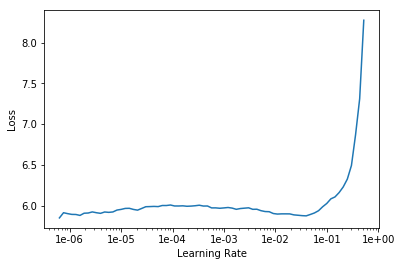

In [8]:
learn.lr_find()
learn.recorder.plot()

## The One Cycle Policy
A relative recent [study](https://arxiv.org/abs/1803.09820) shows that by implementing
* Cyclic Learning Rate
* Cyclic Momentum
where both are inversely proportional, throughout a training cycle helps the model to learn faster and better.

fastai implements this idea through `fit_one_cycle` 


In [9]:
learn.fit_one_cycle(7, max_lr=slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,5.211705,4.353743,0.098894,03:57
1,4.278523,3.181253,0.266585,04:01
2,3.583196,2.294650,0.475430,04:01
3,3.005269,1.736994,0.598280,04:01
4,2.754667,1.479562,0.650491,04:01
5,2.464184,1.380417,0.689803,04:00
6,2.464194,1.350472,0.686732,04:01


Saving checkpoint after every training stage

In [10]:
learn.save('s1-res152-mixup-b16')

## Unfreezing
Before unfreezing, the model is just training the final dense layer. This makes sense because we want the model first to update the last layer which is randomly initialized. This procedure speeds up the whole training pipeline as training the final layer updates significantly less weights.

Now we want the earlier model to learn some features that is specific to identifying cars (imagenet is not trained on cars), we unfreeze the model and allow the parameters to update themselves.

In [11]:
learn.unfreeze() 

Repeating the same step, finding good learning rates. Notice after unfreezing, the diverging region for LRs has increased all the way to 0.001. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


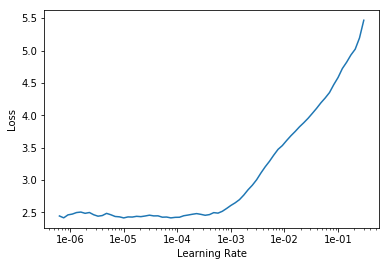

In [12]:
learn.lr_find()
learn.recorder.plot()

Retraining the whole Neural network instead of last layer. `max_lr` takes a `slice` argument. That is telling the model to linearly decrease learning rates as the models goes deeper. 

Earlier layers will have a smaller learning rate, latter one will have higher. This is due to the fact that as the models goes deeper, each layer learns to capture features that is more specific to the problem domain. We want the early layers to update less as they capture more general features such as edge and corners, which are usually general to many vision problems.

In [13]:
learn.fit_one_cycle(10, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,2.410198,1.212968,0.714988,05:27
1,2.520066,1.304535,0.675676,05:26
2,2.508008,1.149926,0.693489,05:27
3,2.274970,0.918626,0.773342,05:27
4,2.065427,0.713868,0.811425,05:27
5,1.812192,0.604409,0.843980,05:26
6,1.680605,0.532055,0.860565,05:26
7,1.579917,0.465038,0.885749,05:26
8,1.537164,0.450862,0.884521,05:26
9,1.389654,0.440426,0.891892,05:26


Our Training Losses are unusually high for a 90% accuracy. Due to mixup, our model makes less confident predictions, therefore resulting in higher loss.

Saving checkpoints ...

In [14]:
learn.save('s2-res152-mixup-b16')

First validation with test data

In [15]:
learn.validate(test_data.valid_dl)

[0.41947034, tensor(0.9032)]

Accuracy is 90.32%! 

## A lot more training from here onwards
* Reduce learning rate more
* Transfer Learning from a mixup model to one without
* Experiment with different weight decay

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


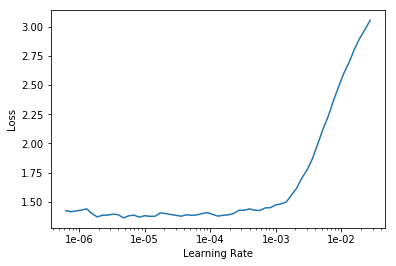

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.397186,0.446562,0.890049,05:26
1,1.438051,0.534962,0.870393,05:26
2,1.400836,0.426708,0.891278,05:27
3,1.376516,0.425192,0.892506,05:26
4,1.400255,0.498842,0.877764,05:28


In [19]:
learn.save('s3-res152-mixup-b16')

In [20]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.383467,0.416708,0.893120,05:26
1,1.387676,0.429911,0.894963,05:27
2,1.346170,0.427946,0.897420,05:28
3,1.399204,0.414521,0.898649,05:26
4,1.393840,0.419956,0.898649,05:26


In [22]:
learn.save('s4-res152-mixup-b16')

## Further Training

In [23]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.334487,0.441778,0.896806,05:26
1,1.429936,0.447499,0.896806,05:27
2,1.442092,0.426784,0.898649,05:27
3,1.366354,0.407731,0.895577,05:28
4,1.335284,0.408706,0.898034,05:26


In [25]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4), wd=0.005)

epoch,train_loss,valid_loss,accuracy,time
0,1.314871,0.410874,0.901106,05:27
1,1.321568,0.410575,0.904791,05:26
2,1.328451,0.413649,0.904791,05:27
3,1.329323,0.406821,0.904177,05:27
4,1.340922,0.406940,0.903563,05:26


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


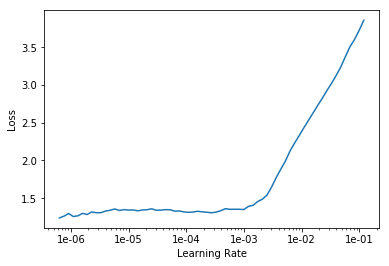

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.save('s5-res152-mixup-b16-v90.35-t91.42')

Our model plateaued in performance. Now we remove the mixup and transfer learn the model with actual data. The idea behind on this procedure is we want the model to learn general features first, then dive deeper into more detailed features.

In [30]:
learn = cnn_learner(data, models.resnet152, metrics=[accuracy]).load('s5-res152-mixup-b16-v90.35-t91.42')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


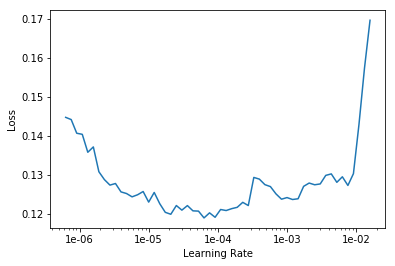

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.124539,0.440722,0.905405,03:52
1,0.089469,0.398467,0.906634,04:01
2,0.075498,0.376810,0.907248,04:01
3,0.058537,0.370777,0.908477,04:01
4,0.058117,0.366259,0.909091,04:00


In [34]:
learn.save('s5-res152-mixup-b16-v90.9-t91.47')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


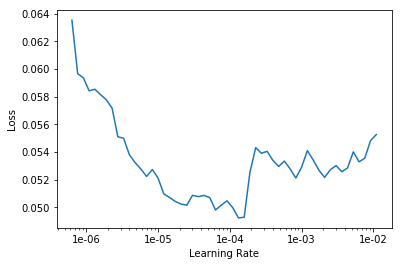

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.059377,0.367200,0.910319,03:53
1,0.050390,0.355818,0.909705,04:00
2,0.041201,0.356811,0.907248,04:00
3,0.040962,0.350874,0.909091,04:00
4,0.035765,0.350596,0.912776,04:00


In [38]:
learn.save('s5-res152-mixup-b16-v91.2-t91.51')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


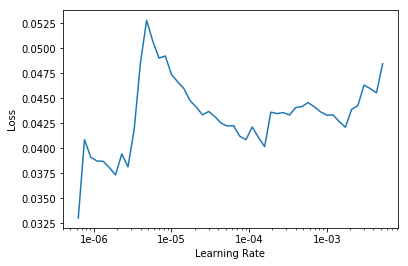

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(5, max_lr=slice(1e-7, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.038683,0.351556,0.908477,03:52
1,0.036911,0.351657,0.909705,04:00
2,0.040841,0.349842,0.909705,04:01
3,0.034099,0.351636,0.913391,04:00
4,0.034340,0.351817,0.907248,04:01


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


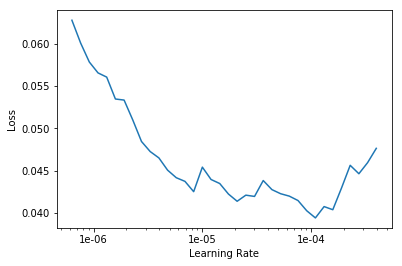

In [44]:
learn.lr_find()
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.051046,0.385345,0.902334,05:19
1,0.073617,0.413424,0.898649,05:28
2,0.054756,0.418001,0.894349,05:29
3,0.034758,0.372799,0.905405,05:28
4,0.022787,0.366694,0.909705,05:27


In [47]:
learn.save('s6-res152-mixup-b16-v91-t91.97')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


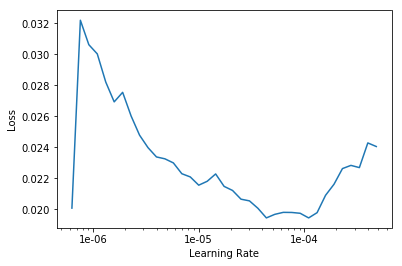

In [48]:
learn.lr_find()
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(10, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.023170,0.366352,0.907248,05:19
1,0.023717,0.366864,0.909091,05:29
2,0.025086,0.373975,0.903563,05:29
3,0.025099,0.380517,0.909091,05:29
4,0.014460,0.379790,0.909705,05:28
5,0.026366,0.376068,0.915233,05:28
6,0.009986,0.376945,0.914619,05:28
7,0.009447,0.366619,0.914619,05:28
8,0.006398,0.369721,0.917076,05:29
9,0.012231,0.368261,0.915848,05:28


In [58]:
learn.save('s7-res152-mixup-b16-v91.58-t92.28')

In [61]:
learn.fit_one_cycle(1, max_lr=slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.012077,0.368580,0.915848,0.915086,0.915176,03:52


/opt/anaconda3/lib/python3.7/site-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


In [63]:
learn.save('s8-res152-mixup-b16-v91.58-t92.35')

Reload the model to output additional performance metrics.

In [25]:
learn = cnn_learner(data, models.resnet152, metrics=[accuracy, Precision(), Recall()]).load('s8-res152-mixup-b16-v91.58-t92.35')

In [26]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


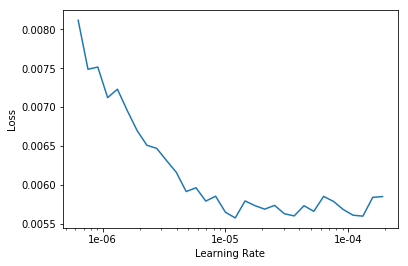

In [13]:
learn.lr_find()
learn.recorder.plot()


In [27]:
learn.fit_one_cycle(10, max_lr=slice(1e-6))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.009007,0.370917,0.915233,0.914966,0.915087,05:38
1,0.009088,0.368555,0.917076,0.916141,0.916492,05:44
2,0.015096,0.367717,0.915848,0.915448,0.915848,05:44
3,0.009220,0.372914,0.915233,0.915191,0.914617,05:44
4,0.007970,0.368329,0.915848,0.915028,0.915022,05:45
5,0.012205,0.371354,0.914619,0.913885,0.914269,05:45
6,0.006841,0.367654,0.915233,0.913734,0.913762,05:44
7,0.008815,0.369113,0.914619,0.912766,0.913307,05:45
8,0.007155,0.372416,0.915848,0.915092,0.915235,05:44
9,0.011143,0.371173,0.917076,0.915581,0.916538,05:44


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


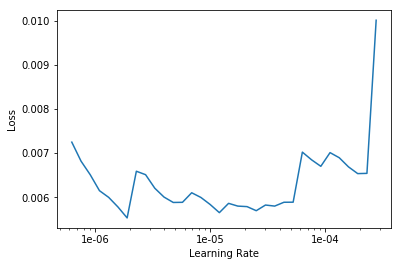

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.save('s9-res152-mixup-b16-v91.78-t92.28')

In [33]:
learn.fit_one_cycle(10, max_lr=slice(1e-5))

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.014399,0.369220,0.914619,0.913709,0.914744,05:36
1,0.010794,0.370232,0.914619,0.913696,0.913864,05:44
2,0.011275,0.373530,0.914005,0.913982,0.913596,05:45
3,0.007956,0.370372,0.914005,0.913382,0.912659,05:45
4,0.007635,0.368641,0.915233,0.912394,0.913761,05:44
5,0.006727,0.367036,0.915848,0.914648,0.914877,05:45
6,0.009953,0.373057,0.915848,0.913929,0.914516,05:44
7,0.010095,0.370387,0.915848,0.915499,0.915002,05:45
8,0.007077,0.368620,0.917076,0.915628,0.914951,05:44
9,0.007726,0.373617,0.912776,0.911415,0.911568,05:45


## Final Testing
Performance has reached an asymptote. Perform a final evaluation on the model based on the test set.

In [38]:
learn.validate(test_data.valid_dl)

[0.32097796, tensor(0.9253), tensor(0.9274), tensor(0.9245)]

**Loss : 0.3209**

**Accuracy : 92.53%**

**Precision : 92.74%** (macro)

**Recall : 92.45%** (macro)

In [ ]:
learn.export('best-model.pkl')